In [1]:
# This is needed for DataFrameMapper
# %pip install sklearn-pandas

In [2]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os

# For SVM stuff
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn_pandas import DataFrameMapper

# To find "Unusual Words"
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('words')
import re

#Set Working Directory
os.chdir(r"/Users/glinn/Documents/CSCI5622-machine-learning/project/csci5622project")

[nltk_data] Downloading package words to /Users/glinn/nltk_data...
[nltk_data]   Package words is already up-to-date!


Format does basic work to change the format of columns into something we can use.

In [3]:
def format_df(df):
    df["deadline"] = pd.to_datetime(df["deadline"])
    df["launched"] = pd.to_datetime(df["launched"])
    df["success"] = df["pledged"] >= df["goal"]
    df["duration"] = df["deadline"] - df["launched"]
    return df

Clean removes columns we don't care about. Namely:
* When the duration is less than one day
* If the project state is 'live'
* If the project state is cancelled

In [4]:
# Taken from Michael's notebook
def clean_df(df):
    df = df.drop(df.loc[df["duration"] < datetime.timedelta(days=1)].index)
    df = df.drop(df.loc[df["state"] == "live"].index)
    df = df.drop(df.loc[df["state"] == "canceled"].index)
    return df

These functions define the transformations of the columns we care about into the forms we're interested in running actual algorithms on. 

In [5]:
def tokenize(text): 
    tknzr = WhitespaceTokenizer()
    return tknzr.tokenize(text)

# TODO: use an embedding instead??
def get_count_vectorizer():
    nltk.download('stopwords')
    en_stopwords = set(stopwords.words("english")) 
    count_vectorizer = CountVectorizer(stop_words=en_stopwords, analyzer='word', tokenizer=tokenize, min_df=1)
    return count_vectorizer

def get_main_category_encoder():
    main_category_le = LabelEncoder()
    main_category_le.fit(train_clean['main_category'])
    return main_category_le

def get_category_encoder():
    category_le = LabelEncoder()
    category_le.fit(train_clean['category'])
    return category_le

#Now write functions to extract basic features from the name:
def WordsList(Text):
    wordList = re.sub("[^\w]", " ",  Text).split()
    return wordList

def get_unusual_words(text):
    Words = WordsList(text)
    text_vocab = set(w.lower() for w in Words if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab - english_vocab
    return len(sorted(unusual))

def get_Num_Weird_Chars(Name):
    NumWeirdChars = sum(not c.isalnum() for c in Name) - sum(c.isspace() for c in Name)
    return NumWeirdChars
####

def get_mapper():
    main_category_le = get_main_category_encoder()
    category_le = get_category_encoder()
    count_vectorizer = get_count_vectorizer()

    mapper = DataFrameMapper([
        ('main_category', main_category_le),
        ('category', category_le),
        (['duration'], StandardScaler()),
        (['usd_goal_real'], StandardScaler()),
        (['launched_month', 'deadline_month'], OrdinalEncoder()),
    ], df_out=True)
    return mapper

def transform_df(df, mapper, fit=False):
    X = df[["name", "main_category", "category", "duration", "usd_goal_real"]].copy()
    X["launched_month"] = df["launched"].apply(lambda x: x.month)
    X["deadline_month"] = df["deadline"].apply(lambda x: x.month)
    X["duration_seconds"] = X["duration"].apply(lambda x: x.seconds)
    
    if fit:
        X_mapped = mapper.fit_transform(X)
    else:
        X_mapped = mapper.transform(X)
        
    y = df["success"].copy()
    
    return X_mapped, y, mapper
    

In [6]:
# Taken from Michael's notebook
train_full = pd.read_csv("data/2018-train.csv").dropna()
validate_full = pd.read_csv("data/2018-validate.csv").dropna()

In [7]:
# Taken from Michael's notebook
train_format = format_df(train_full)
validate_format = format_df(validate_full)

In [8]:
# Taken from Michael's notebook
train_clean = clean_df(train_format)
valid_clean = clean_df(validate_format)
train_clean.head(3)

,Unnamed: 0,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,success,duration
0,319122,695425648,Peace-building through story-making with youth...,Children's Books,Publishing,SEK,2015-06-09,6000.0,2015-05-10 14:53:53,6251.0,successful,15,SE,756.92,762.02,731.42,True,29 days 09:06:07
2,175494,189251239,Colored Baggies for Boardgames,Tabletop Games,Games,USD,2013-01-07,6000.0,2012-11-08 20:06:31,15151.0,successful,518,US,15151.00,15151.00,6000.00,True,59 days 03:53:29
4,141771,1720248225,Two Scoops of Beauty health wellness women eve...,Events,Food,USD,2016-09-04,5202.0,2016-08-05 01:26:56,0.0,failed,0,US,0.00,0.00,5202.00,False,29 days 22:33:04


In [9]:
%%time
mapper = get_mapper()
X_train, y_train, mapper = transform_df(train_clean, mapper, fit=True)
X_valid, y_valid, mapper = transform_df(valid_clean, mapper, fit=False)

[nltk_data] Downloading package stopwords to /Users/glinn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 5.35 s, sys: 74.1 ms, total: 5.42 s
Wall time: 4.87 s


I will append features for the name below, because I didn't know how to use the df mapper structure

In [10]:
%%time
X_train["num_chars"]=train_clean["name"].apply(lambda x: len(x))
X_train["num_unusual_words"]=train_clean["name"].apply(lambda x: get_unusual_words(x))
X_train["num_weird_chars"]=train_clean["name"].apply(lambda x: get_Num_Weird_Chars(x))

X_valid["num_chars"]=valid_clean["name"].apply(lambda x: len(x))
X_valid["num_unusual_words"]=valid_clean["name"].apply(lambda x: get_unusual_words(x))
X_valid["num_weird_chars"]=valid_clean["name"].apply(lambda x: get_Num_Weird_Chars(x))

CPU times: user 10h 45min 21s, sys: 45min, total: 11h 30min 21s
Wall time: 11h 49min 26s


In [11]:
X_train.head(5)

,main_category,category,duration,usd_goal_real,launched_month_deadline_month_0,launched_month_deadline_month_1,num_chars,num_unusual_words,num_weird_chars
0,12,19,-0.316333,-0.036515,4.0,5.0,56,1,2
2,8,136,2.025723,-0.031740,10.0,0.0,30,2,0
4,7,44,-0.272265,-0.032463,7.0,8.0,60,4,0
5,5,31,-0.400095,-0.034948,2.0,3.0,34,3,1
6,6,93,-0.326225,0.008140,0.0,2.0,49,2,6


In [12]:
y_train.head(5)

0     True
2     True
4    False
5    False
6    False
Name: success, dtype: bool

# So are these new name features any good or what?

the standard deviation is 15.949280596845314


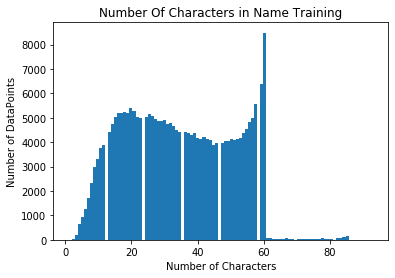

In [13]:
plt.hist(X_train["num_chars"],bins=100)
plt.title("Number Of Characters in Name Training")
plt.xlabel("Number of Characters")
plt.ylabel("Number of DataPoints")
std_train = np.std(X_train["num_chars"])
print(f"the standard deviation is {std_train}")

the standard deviation is 15.981867898640875


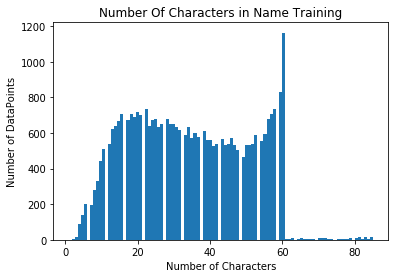

In [14]:
plt.hist(X_valid["num_chars"],bins=100)
plt.title("Number Of Characters in Name Training")
plt.xlabel("Number of Characters")
plt.ylabel("Number of DataPoints")
std_valid = np.std(X_valid["num_chars"])
print(f"the standard deviation is {std_valid}")

the standard deviation is 1.349615980111067


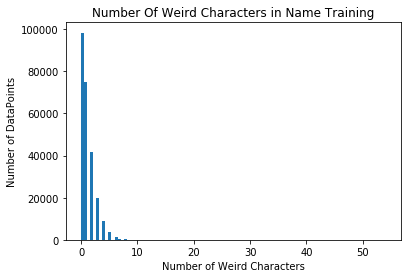

In [15]:
plt.hist(X_train["num_weird_chars"],bins=100)
plt.title("Number Of Weird Characters in Name Training")
plt.xlabel("Number of Weird Characters")
plt.ylabel("Number of DataPoints")
std_train = np.std(X_train["num_weird_chars"])
print(f"the standard deviation is {std_train}")

the standard deviation is 1.357160867663027


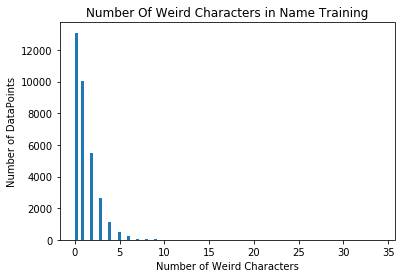

In [16]:
plt.hist(X_valid["num_weird_chars"],bins=100)
plt.title("Number Of Weird Characters in Name Training")
plt.xlabel("Number of Weird Characters")
plt.ylabel("Number of DataPoints")
std_valid = np.std(X_valid["num_weird_chars"])
print(f"the standard deviation is {std_valid}")

the standard deviation is 1.0460406165876468


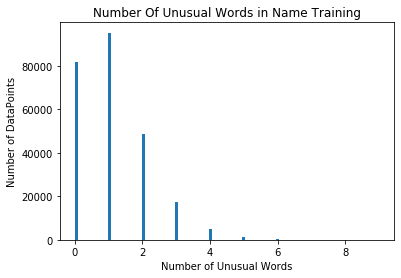

In [19]:
plt.hist(X_train["num_unusual_words"],bins=100)
plt.title("Number Of Unusual Words in Name Training")
plt.xlabel("Number of Unusual Words")
plt.ylabel("Number of DataPoints")
std_valid = np.std(X_train["num_unusual_words"])
print(f"the standard deviation is {std_valid}")

the standard deviation is 1.0494476091112466


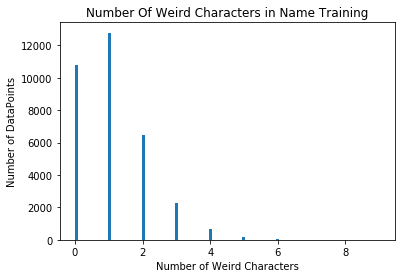

In [17]:
plt.hist(X_valid["num_unusual_words"],bins=100)
plt.title("Number Of Weird Characters in Name Training")
plt.xlabel("Number of Weird Characters")
plt.ylabel("Number of DataPoints")
std_valid = np.std(X_valid["num_unusual_words"])
print(f"the standard deviation is {std_valid}")

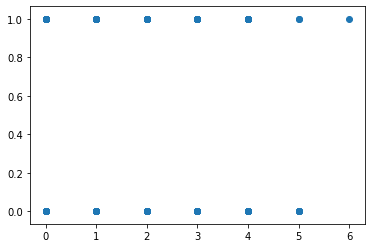

In [24]:
plt.scatter(X_train.iloc[0:1000]["num_unusual_words"],y_train[0:1000])

In [41]:
ind1 = np.where(y_train==1)
ind0 = np.where(y_train==1)
print(np.mean(X_train.iloc[ind1[0]]["num_chars"]))
print(np.mean(X_train.iloc[ind0[0]]["num_chars"]))
plt.hist(X_train.iloc[ind1[0]],bins=100)
plt.hist(X_train.iloc[ind0[0]],bins=100)

36.28451995148816
36.28451995148816


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11706a048> (for post_execute):


KeyboardInterrupt: 

36.22444059368643
36.22444059368643


(array([ 418., 1496., 2226., 2051., 1960., 2208., 2324.,  529.,   25.,
          36.]),
 array([ 1. ,  9.4, 17.8, 26.2, 34.6, 43. , 51.4, 59.8, 68.2, 76.6, 85. ]),
 <a list of 10 Patch objects>)

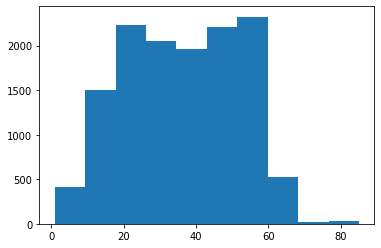

In [49]:
ind1 = np.where(y_valid==1)
ind0 = np.where(y_valid==1)
print(np.mean(X_valid.iloc[ind1[0]]["num_chars"]))
print(np.mean(X_valid.iloc[ind0[0]]["num_chars"]))
plt.subplots()
plt.hist(X_valid.iloc[ind1[0]]["num_chars"],bins=10)
plt.hist(X_valid.iloc[ind0[0]]["num_chars"],bins=10)

In [18]:
# TODO: write to file
X_train.to_csv("data/preprocess-basic_name-x-train.csv")
y_train.to_csv("data/preprocess-basic_name-y-train.csv")
X_valid.to_csv("data/preprocess-basic_name-x-valid.csv")
y_valid.to_csv("data/preprocess-basic_name-y-valid.csv")

/Users/glinn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/glinn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
